# Skin Cancer Detection
## LIME Explanation for Vision Transformer (ViT) Image Classification
Realized by Omer, Samuele, Velina

Requires: `numpy`, `torch`, `matplotlib`, `transformers`, `lime`, `scikit-image`, and `Pillow`, and an image file (e.g., `skin_cancer_pic3.jpg`).

In [8]:
import numpy as np
import os 
import torch
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

### Configuration and Model Loading
Define the pre-trained model name and load the ViT model and its corresponding feature extractor. The `num_labels=7` parameter adapts the final classification layer of the pre-trained model to output scores for 7 classes.

Labels used in classification:

0. `benign_keratosis-like_lesions`,
    
1. `basal_cell_carcinoma`,
    
2. `actinic_keratoses`,
    
3. `vascular_lesions`,
    
4. `melanocytic_Nevi`,
    
5. `melanoma`,
    
6. `dermatofibroma`

In [9]:
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=7)  # Adjust num_labels for your dataset
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/skin_detection/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Helper Functions

Define the necessary functions for preprocessing the image, getting predictions from the model (in the format LIME expects), and performing the LIME explanation.

In [10]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs["pixel_values"], np.array(image)

### Predict function for LIME

In [11]:
def predict(images):
    model.eval()
    inputs = [feature_extractor(images=Image.fromarray(img), return_tensors="pt")["pixel_values"] for img in images]
    inputs = torch.cat(inputs)  
    with torch.no_grad():
        outputs = model(inputs)
    return torch.nn.functional.softmax(outputs.logits, dim=-1).numpy()

### Explain with LIME function
Note that: 
`top_labels=1` so it only explains the top predicted label; 
`hide_color=0` to set the background color for masked parts; 
`num_samples=200` represents the number of perturbations;
`num_features=5` represents the number of superpixels(features) to highlight

In [12]:
def explain_with_lime(image_path):
    
    pixel_values, original_image = preprocess_image(image_path) 
    
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        original_image, 
        predict, 
        top_labels=1,   
        hide_color=0,   
        num_samples=200  
    )

    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label=top_label, 
        positive_only=True, 
        num_features=5,  
        hide_rest=False
    )

    explained_image = mark_boundaries(temp, mask)
    plt.figure(figsize=(10, 10))
    plt.imshow(explained_image)
    plt.title(f"Explanation for Label: {model.config.id2label.get(top_label, 'Unknown')}")
    plt.axis("off")
    plt.show()

## Run Explanation

Set the path to your image file and call the `explain_with_lime` function (assuming the image is in the same directory as the notebook). Remember to define the filename of the image you want to explain.

In [13]:
image_dir = "." 
image_filename = "skin_cancer_pic3.jpg" 
image_path = os.path.join(image_dir, image_filename)

100%|██████████| 200/200 [00:12<00:00, 15.81it/s]


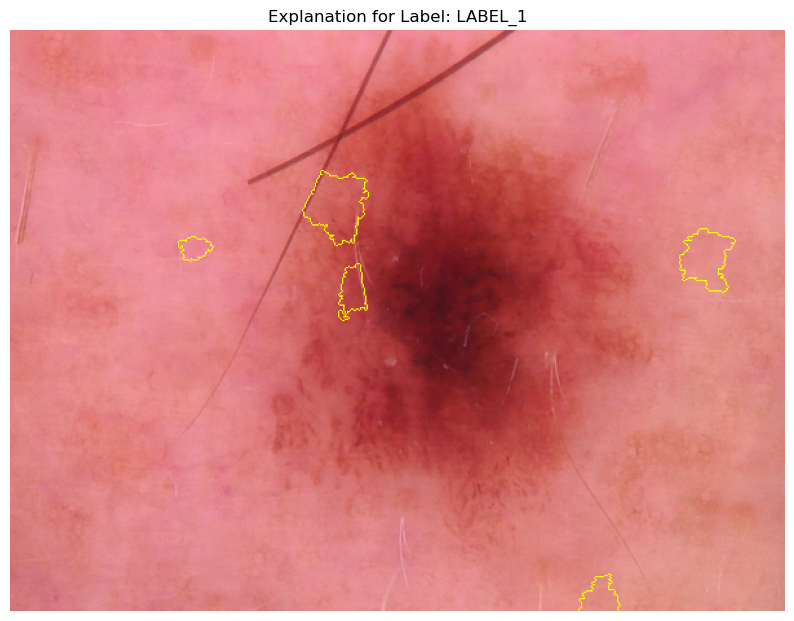

In [14]:
explain_with_lime(image_path)